# Загрузка Pandas и очистка данных

In [68]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [69]:
df = pd.read_csv('main_task.xls')

In [70]:
#Смотрим на типы данных в стобцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Колонки Cuisine Style,Price Range и Number of Reviews содержат пропуски в данных - их нужно будет заполнить либо удалить сам стоблец.

## Обработка признаков и создание новых

### Уровень цен (Price Range)

In [71]:
df['Price Range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [72]:
len(df[df['Price Range']=='$$ - $$$'])

18412

Столбец содержит значения в формате символов - их нужно перевести в числовой формат:

In [73]:
def convert_prices_to_numeric(x):
    if x=='$':
        return 1
    elif x=='$$ - $$$':
        return 2
    elif x=='$$$$':
        return 3

In [74]:
df['Price']=df['Price Range'].apply(convert_prices_to_numeric)

Теперь попробуем заполнить пропуски в данных средним значением по столбцу:

In [75]:
df['Price'].fillna(df['Price'].mean())

0        2.000000
1        1.814046
2        3.000000
3        1.814046
4        2.000000
           ...   
39995    2.000000
39996    2.000000
39997    1.814046
39998    2.000000
39999    2.000000
Name: Price, Length: 40000, dtype: float64

Среднее значение получилось дробным, что не позволяет отнести его к одному из трех уровней цен - поэтому используем медиану вместо среднего.

In [76]:
df['Price']=df['Price'].fillna(df['Price'].median())

Теперь данные об уровне цен в ресторанах имеют числовые значения и могут быть добавлены в качестве параметра:

In [77]:
df['Price'].unique()

array([2., 3., 1.])

### Города (City)

In [78]:
df['City'].unique()

array(['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Oporto',
       'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid',
       'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
       'Luxembourg', 'Krakow'], dtype=object)

In [79]:
df['City'].nunique()

31

У нас есть данные о ресторанах в 31 городе - при этому пропуски отсутствуют.

Для того чтобы добавить признак города в выборку создадим отдельный dataframe, в котором каждый столбец будет соответствовать одному городу из списка со значениями 0 или 1 в зависимости от того, относится наблюдение к этому городу или нет.

In [80]:
cities=pd.DataFrame()
for city in df['City'].unique():
    cities[city]=(df['City']==city).astype(int)

In [81]:
cities.head()

,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,...,Lisbon,Prague,Oslo,Helsinki,Edinburgh,Geneva,Ljubljana,Athens,Luxembourg,Krakow
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Добавим в новый датафрейм колонку с рейтингом:

In [82]:
cities['Rating']=df['Rating']

Затем построим матрицу корреляции и опытным путем выясним, для каких городов коэффициент корреляции с рейтингом окажется больше, чем для остальных - именно сведения о них стоит включить в выборку.

In [83]:
#с помощью iloc[:-1] убираем коэффициент корреляции rating с самим собой
#nlargest() возвращает n-максимальных значений в ряду данных
most_important_cities=cities.corr()['Rating'].iloc[:-1].nlargest(5).index.values.tolist() 

In [84]:
df['Important_cities']=df['City'].apply(lambda x: 1 if x in most_important_cities else 0)

По аналогии с этим, выберем города, для которых коэффициент корреляции минимален (то есть наиболее сильная отрицательная зависимость).

In [85]:
least_important_cities=cities.corr()['Rating'].iloc[:-1].nsmallest(3).index.values.tolist() 

In [86]:
df['Less_important_cities']=df['City'].apply(lambda x: 1 if x in least_important_cities else 0)

Помимо этого мы можем выделить топ-5 городов, которые в целом наиболее часто встречаются в выборке, и также использовать эту информацию для построения модели.

In [87]:
df['Popular_cities']=df['City'].apply(lambda x: 1 if x in df['City'].value_counts().head(5) else 0)

### Кухня (Cuisine Style)

In [88]:
df['Cuisine Style'].unique()

array(["['European', 'French', 'International']", nan,
       "['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",
       ...,
       "['Steakhouse', 'Barbecue', 'Australian', 'Argentinean', 'South American']",
       "['French', 'American', 'Cafe', 'Healthy', 'Soups']",
       "['French', 'Contemporary', 'Fusion', 'Gastropub']"], dtype=object)

Строки столбца представляют собой скрытые списки + присутствуют пропущенные значения (None) - поэтому для извлечения оттуда информации сначала заполним пропуски и удалим лишние скобы и кавычки.

*Так как в столбце содержатся данные о видах кухни, то в данном случае имеет смысл заполнить пропуски придуманной категорией "Other" ('Другая'):*

In [89]:
df['Cuisine Style']=df['Cuisine Style'].fillna('Other')

In [90]:
df['Cuisine Style']=df['Cuisine Style'].str.strip("[]").str.replace("'","")

Теперь посчитаем общее число уникальных значений в столбце (разновидностей кухни):

In [91]:
#Не забываем, что одну из категорий ("Other") мы добавили сами
list_of_cuisine=pd.DataFrame(df['Cuisine Style'].astype(str).str.split(',').tolist()).stack().str.strip()
list_of_cuisine.nunique()

126

Определим наиболее популярную разновидность кухни, используя метод value_counts:

In [92]:
list_of_cuisine.value_counts()

Vegetarian Friendly    11189
European               10060
Other                   9283
Mediterranean           6277
Italian                 5964
                       ...  
Burmese                    1
Salvadoran                 1
Xinjiang                   1
Latvian                    1
Yunnan                     1
Length: 126, dtype: int64

Теперь посчитаем число разновидностей кухонь для каждого ресторана и найдем, какое число разных кухонь в среднем предлагает каждое заведение:

In [93]:
number_of_cuisine=list_of_cuisine.reset_index().groupby(['level_0'])[0].count()
round(number_of_cuisine.mean(),1)

2.6

Добавим в данные столбец, отражающий количество различных кухонь в одном заведения:

In [94]:
df['Number of cuisines']=list_of_cuisine.reset_index().groupby(['level_0'])[0].count()

Также сейчас в мире активно набирает популярность вегетарианская кухня (и вегетарианство как идея в целом), поэтому можно предположить, что наличие такой опции будет для ресторана значимым преимуществом - добавим столбец, обозначающий наличие/отсутствие вегетарианских блюд в меню ресторана (1/0):

In [95]:
df['Vegetarian Friendly']=df['Cuisine Style'].apply(lambda x: 1 if 'Vegetarian Friendly' in x else 0)

### Отзывы (Reviews)

Используем регулярные выражения, чтобы вытащить из данных информацию о дате последнего отзыва (по каждому ресторану):

In [96]:
def last_review(row):
    pd.DataFrame()
    pattern = re.compile('\d+[/]\d+[/]\d+')
    list_of_date=pattern.findall(row)
    if not list_of_date:
        return None
    else:
        list_of_date=[pd.to_datetime(date) for date in list_of_date]
        return max(list_of_date)

In [97]:
recent_review=df['Reviews'].apply(last_review)

Затем находим самый свежий отзыв на сайте в целом:

In [98]:
most_recent_review=recent_review.max()
most_recent_review

Timestamp('2018-02-26 00:00:00')

Теперь, используя эти данные, можно посчитать количество дней между самым свежим отзывом для каждого ресторана и самым свежим отзывом на сайте (то есть понять, насколько давно публиковался последний отзыв для того или иного ресторана):

In [99]:
df['Last_review_days_ago']=most_recent_review-recent_review

In [100]:
df['Last_review_days_ago']=df['Last_review_days_ago'].apply(lambda x: x.days)

*Осталось заполнить пропуски в новых столбцах.*

Пропуски в столбце с количеством отзывов можно заполнить средним значением по столбцу:

In [101]:
df['Number of Reviews']=df['Number of Reviews'].fillna(df['Number of Reviews'].mean())

Так как в столбце last_review_date содержатся данные о количестве дней, прошедших с даты публикации последнего отзыва о ресторане до даты публикации самого свежего отзыва на сайте, то пропущенные значения, которые обозначают отсутствие отзывов о ресторане, можно заполнить максимальным значением по столбцу, то есть считать их наиболее устаревшими:

In [102]:
df['Last_review_days_ago']=df['Last_review_days_ago'].fillna(df['Last_review_days_ago'].max())

## Дополнительная обработка

In [103]:
#Удаляем нечисловые столбцы
df.drop(columns=['Restaurant_id','City','Cuisine Style','Price Range','Reviews','URL_TA','ID_TA'], inplace=True)

In [104]:
#Смотрим, остались ли в каких-то столбцах пропущенные значения
df.isna().any()

Ranking                  False
Rating                   False
Number of Reviews        False
Price                    False
Important_cities         False
Less_important_cities    False
Popular_cities           False
Number of cuisines       False
Vegetarian Friendly      False
Last_review_days_ago     False
dtype: bool

### Матрица корреляции

Построим матрицу корреляции, чтобы выяснить, какие признаки коррелируют с целевой переменной, а какие между собой.

In [105]:
df.corr()

,Ranking,Rating,Number of Reviews,Price,Important_cities,Less_important_cities,Popular_cities,Number of cuisines,Vegetarian Friendly,Last_review_days_ago
Ranking,1.000000,-0.368371,-0.213312,-0.026525,-0.143977,0.262376,0.594109,-0.320250,-0.300139,0.138049
Rating,-0.368371,1.000000,0.027969,-0.028588,0.118966,-0.103518,-0.065014,0.120059,0.128356,-0.039875
Number of Reviews,-0.213312,0.027969,1.000000,0.112054,0.054763,0.001037,-0.020512,0.389268,0.349710,-0.161711
Price,-0.026525,-0.028588,0.112054,1.000000,-0.051032,0.040037,0.021301,0.003177,0.019858,0.080393
Important_cities,-0.143977,0.118966,0.054763,-0.051032,1.000000,-0.255712,-0.116727,0.048124,0.068710,0.008705
Less_important_cities,0.262376,-0.103518,0.001037,0.040037,-0.255712,1.000000,0.377642,-0.132099,-0.087945,0.173276
Popular_cities,0.594109,-0.065014,-0.020512,0.021301,-0.116727,0.377642,1.000000,-0.072427,-0.019778,-0.002777
Number of cuisines,-0.320250,0.120059,0.389268,0.003177,0.048124,-0.132099,-0.072427,1.000000,0.691884,-0.341556
Vegetarian Friendly,-0.300139,0.128356,0.349710,0.019858,0.068710,-0.087945,-0.019778,0.691884,1.000000,-0.313855
Last_review_days_ago,0.138049,-0.039875,-0.161711,0.080393,0.008705,0.173276,-0.002777,-0.341556,-0.313855,1.000000


Для наглядности построим heatmap:

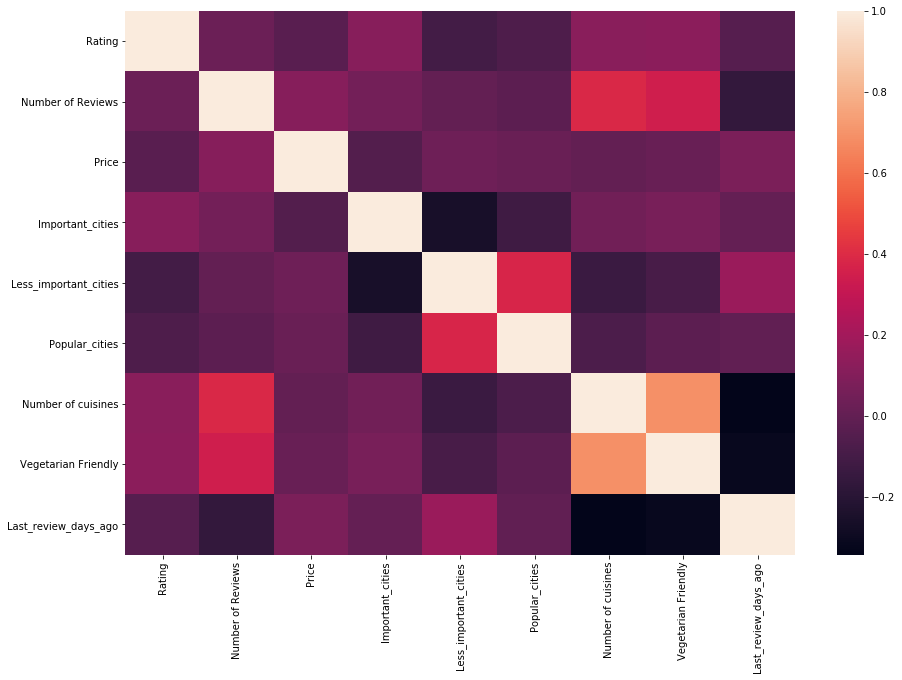

In [106]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['Ranking'], axis=1).corr(),)

Наиболее светлыми участками являются зоны корреляции между признаками "Number of cuisines" и "Vegetarian Friendly", то есть между признаками присутствует сильная корреляция - это вполне объяснимо, так как эти два признака сгенерированы из одного общего ("Cuisine Style").

Также относительно сильно коррелируют такие пары признаков, как "Number of Reviews" и "Number of cuisines", "Number of Reviews" и "Vegetarian Friendly", "Less_important_cities" и "Popular_cities".

Что касается **целевой переменной**, то в целом нельзя сказать о значимой корреляции с каким-либо из признаков, однако у "Important_cities","Number_of_cuisines" и "Vegetarian Friendly" коэффициент корреляции все-таки немного выше.

**Теперь данные обработаны и готовы для построения модели.**

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [107]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [108]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [109]:
# Фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы
RANDOM_SEED = 42

In [110]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 25% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [111]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [112]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [113]:
y_pred

array([4.45 , 4.875, 4.19 , ..., 4.13 , 4.375, 4.21 ])

In [114]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.3062168011904762


Оценим значимость параметров на уже постоенной модели:

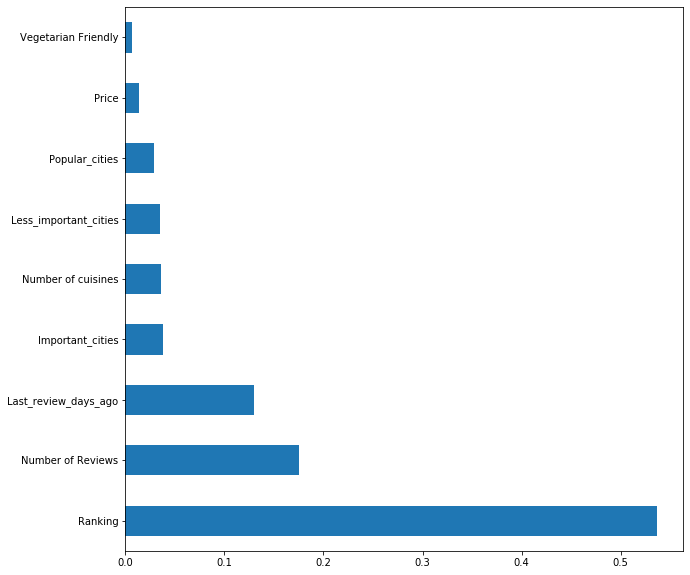

In [115]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Наиболее значимыми для модели являются показатели ranking, number of reviews (количество отзывов) и last_review_days_ago(количество дней, прошедших с последнего отзыва).

#### Итак, с помощью обработки данных и создания новых фичей нам удалось понизить среднюю абсолютную ошибку с 0,42 до 0,30 и построить более качественную модель, предсказывающую реальные оценки ресторанов на сервисе TripAdvisor.

In [116]:
result=pd.DataFrame(y_pred).reset_index()
result.columns=['Restaurant_id','Rating']
result['Restaurant_id']='id_'+result['Restaurant_id'].astype(str)
result.set_index('Restaurant_id', drop=True, inplace=True)
result
result.to_csv('submission.csv')